In [1]:
# Libraries that I'll use throughout the notebook.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# Data used for time series analysis.
path = "../../../Data/playground-series-s5e1/"
train = pd.read_csv(path+"train.csv", 
                    index_col=["date"], 
                    parse_dates=["date"], 
                    usecols=["date", "country", "store", "product", "num_sold"])
test = pd.read_csv(path+"test.csv", 
                   index_col=["date"],
                   parse_dates=["date"], 
                   usecols=["date", "country", "store", "product"])

In [3]:
# For now filling mean the non-optimal way.
num_sold_mean = np.mean(train["num_sold"])
train["num_sold"] = train["num_sold"].fillna(num_sold_mean)

In [4]:
# This ensures that sales of a particular follow each other.
train = train.sort_values(by=["country","date"])
test = test.sort_values(by=["country", "date"])

In [5]:
# Adding the lag of the target variable from 6 steps back up to 24.
for i in range(6, 25):
    li = []
    # Ensures that lag is performed per country.
    for country in train["country"].unique():
        data = train[train["country"]==country]["num_sold"].shift(i)
        li.append(data.values)
    arr = np.array(li)
    train[f"lag_{i}"] = arr.flatten()

In [6]:
one_hot = OneHotEncoder()
cat_train = one_hot.fit_transform(train[["country", "store", "product"]]).toarray()
cat_train = pd.DataFrame(cat_train, 
                         columns=["country_1", "country_2", "country_3", 
                                  "country_4", "country_5", "country_6", 
                                  "store_1", "store_2", "store_3", 
                                  "product_1", "product_2", "product_3", 
                                  "product_4", "product_5"], 
                         index=train.index)

In [7]:
train.drop(["country", "store", "product"], axis=1, inplace=True)
train = pd.concat([train, cat_train], axis=1)

Great, we have generated a dataset here. Why don't we now train a model?

In [9]:
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test
y = train.dropna().num_sold
X = train.dropna().drop(["num_sold"], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

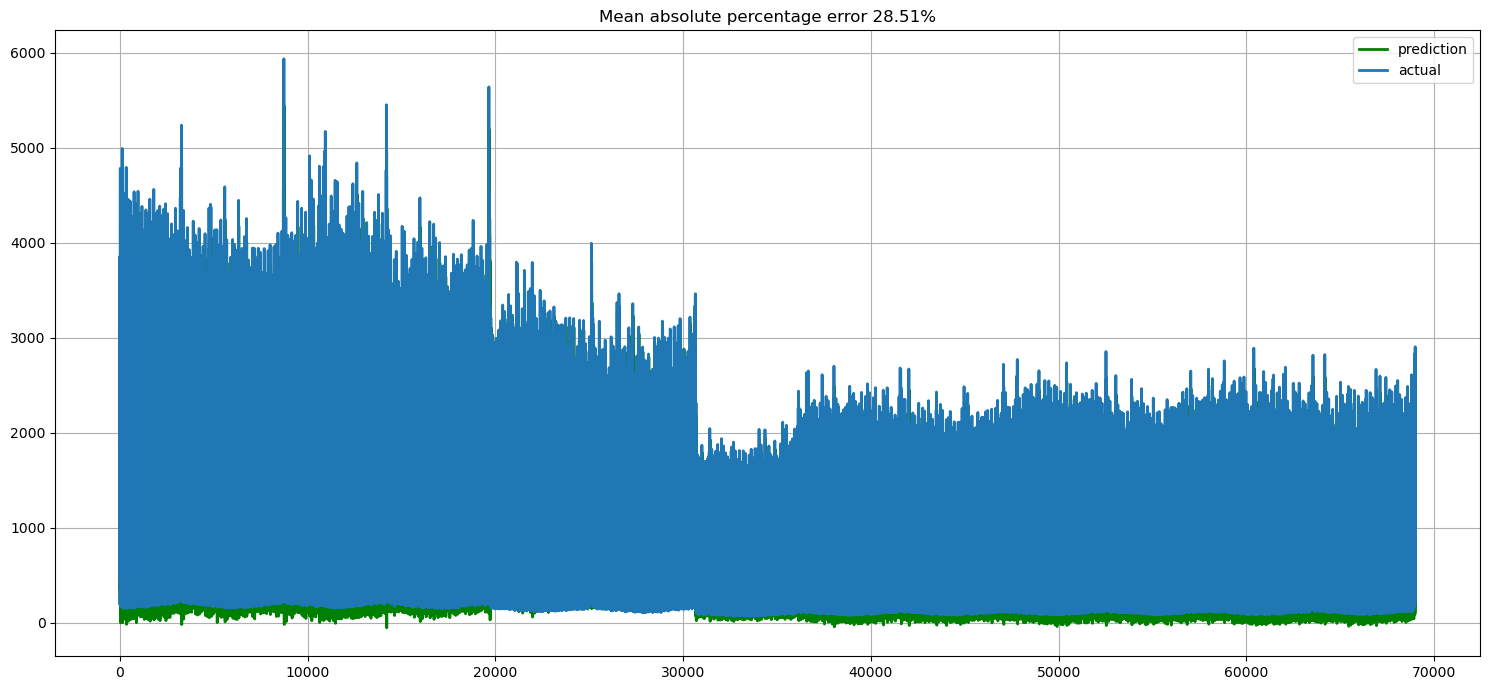

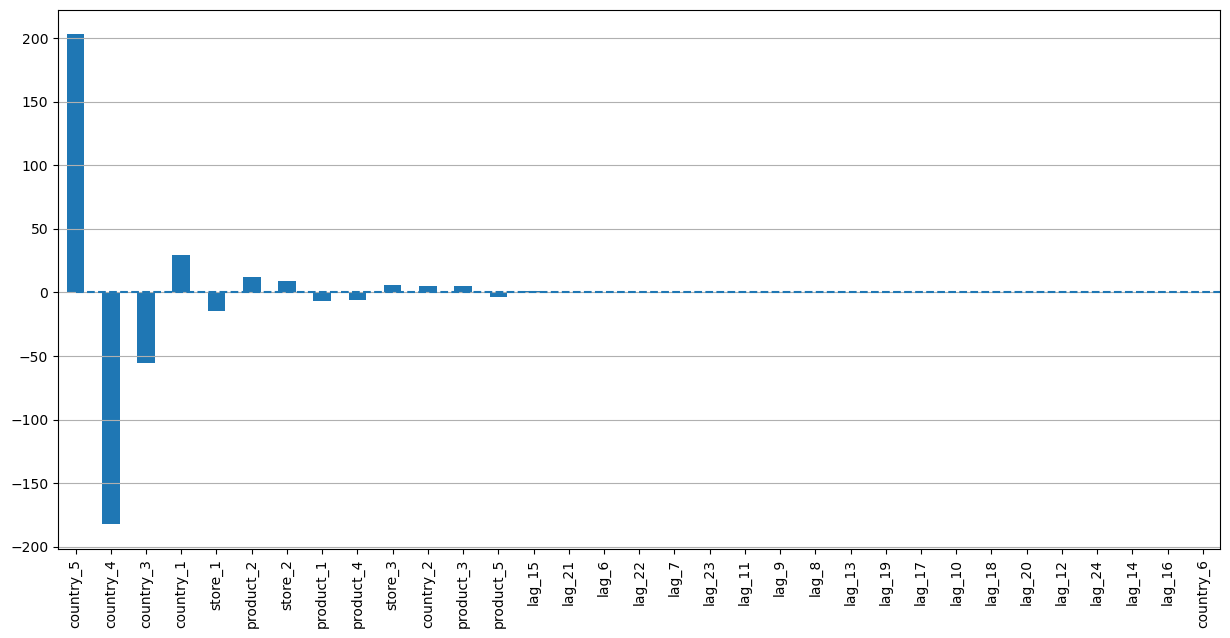

In [10]:

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
       # plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        #plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Simple lags and linear regression gave us predictions that are not that far off from SARIMA in terms of quality. There are many unnecessary features, so we'll do feature selection in a little while. For now, let's continue engineering!

We'll add hour, day of week, and a boolean for is_weekend. To do so, we need to transform the current dataframe index into the datetime format and extract hour and weekday.


In [12]:
train.index = pd.to_datetime(train.index)
train["hour"] = train.index.hour
train["weekday"] = train.index.weekday
train['is_weekend'] = train.weekday.isin([5,6])*1
train.tail()

,num_sold,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,store_2,store_3,product_1,product_2,product_3,product_4,product_5,hour,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2016-12-31,466.0,637.0,556.0,931.0,1259.0,200.0,1518.0,1253.0,2109.0,2822.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,5,1
2016-12-31,2907.0,384.0,637.0,556.0,931.0,1259.0,200.0,1518.0,1253.0,2109.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,5,1
2016-12-31,2299.0,2380.0,384.0,637.0,556.0,931.0,1259.0,200.0,1518.0,1253.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,5,1
2016-12-31,1242.0,2103.0,2380.0,384.0,637.0,556.0,931.0,1259.0,200.0,1518.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,5,1
2016-12-31,1622.0,1052.0,2103.0,2380.0,384.0,637.0,556.0,931.0,1259.0,200.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,5,1


We can visualize the resulting features.

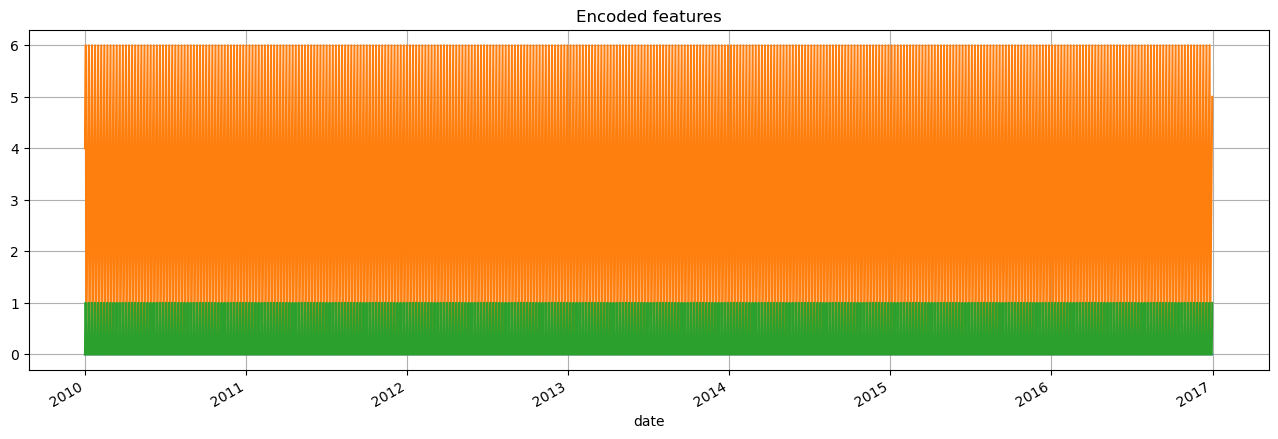

In [14]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
train.hour.plot()
train.weekday.plot()
train.is_weekend.plot()
plt.grid(True);

Since we now have different scales in our variables, thousands for the lag features and tens for categorical, we need to transform them into same scale for exploring feature importance and, later, regularization.

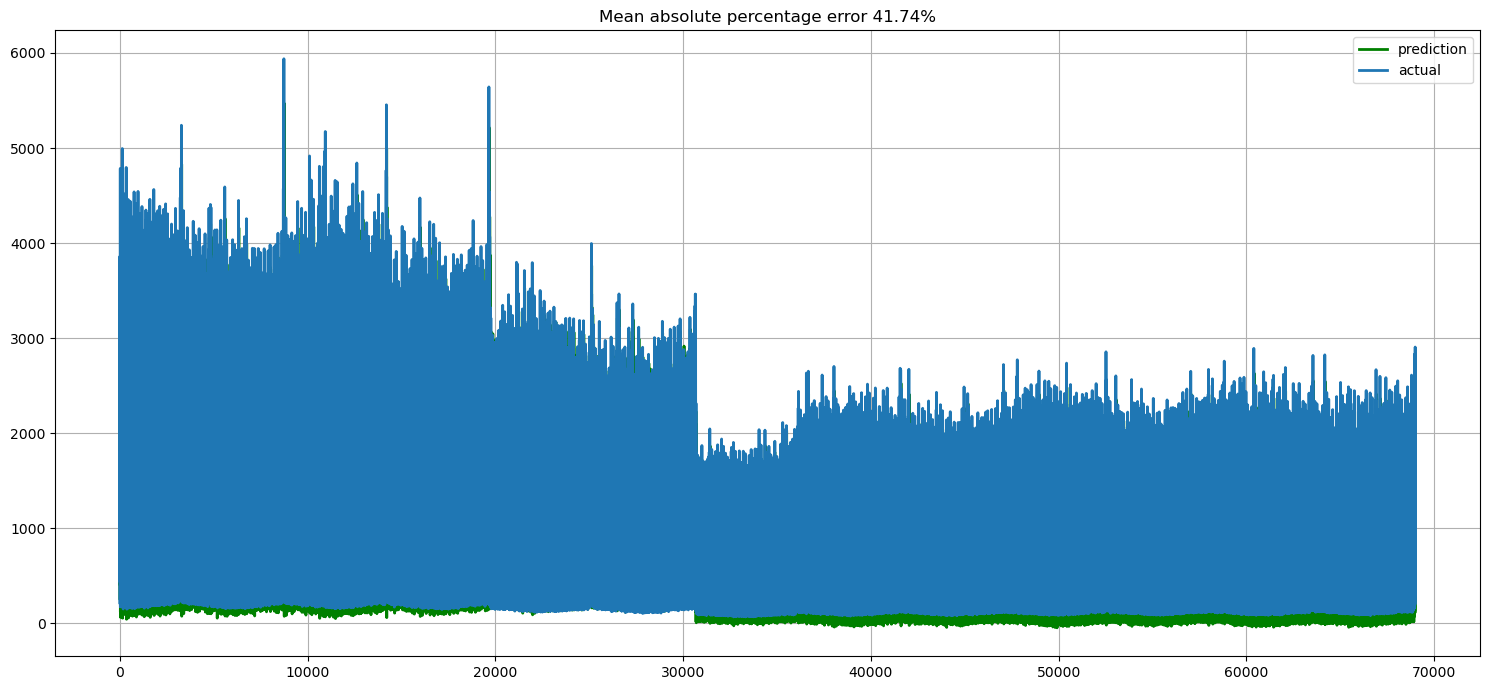

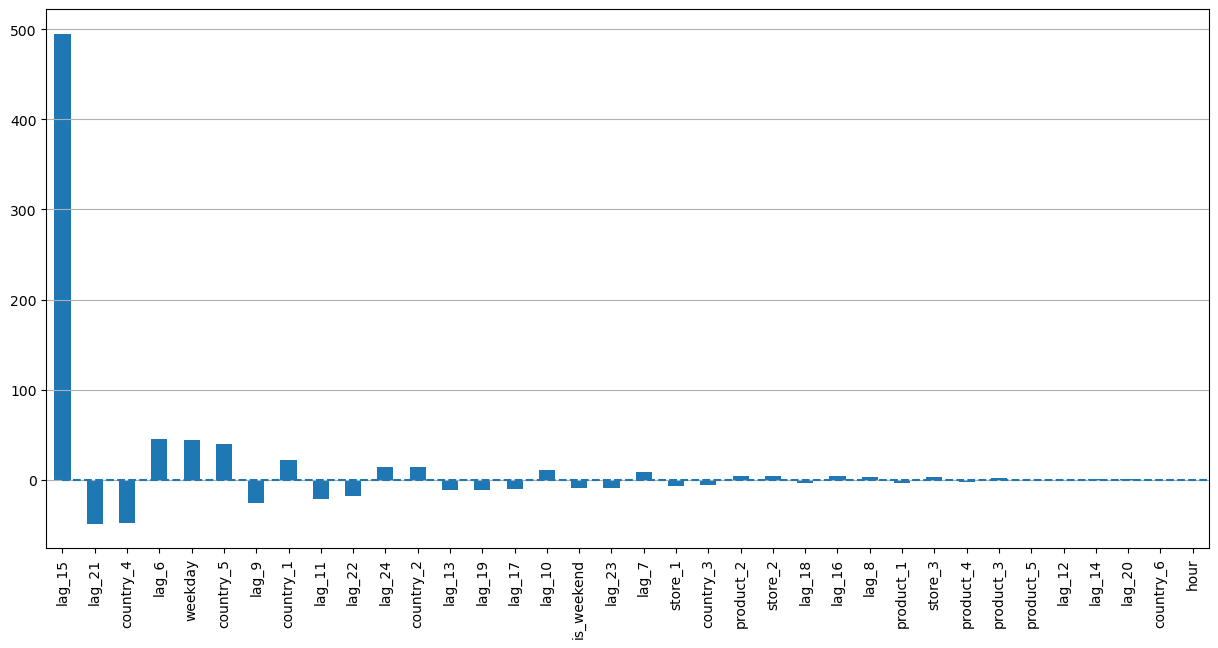

In [16]:
scaler = StandardScaler()
y = train.dropna().num_sold
X = train.dropna().drop(["num_sold"], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

The test error goes down a little bit. Judging by the coefficients plot, we can say that weekday and is_weekend are useful features.


Target encoding
I'd like to add another variant for encoding categorical variables: encoding by mean value. If it is undesirable to explode a dataset by using many dummy variables that can lead to the loss of information and if they cannot be used as real values because of the conflicts like "0 hours < 23 hours", then it's possible to encode a variable with slightly more interpretable values. The natural idea is to encode with the mean value of the target variable. In our example, every day of the week and every hour of the day can be encoded by the corresponding average number of ads watched during that day or hour. It's very important to make sure that the mean value is calculated over the training set only (or over the current cross-validation fold only) so that the model is not aware of the future.


In [19]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Let's look at the averages by hour.

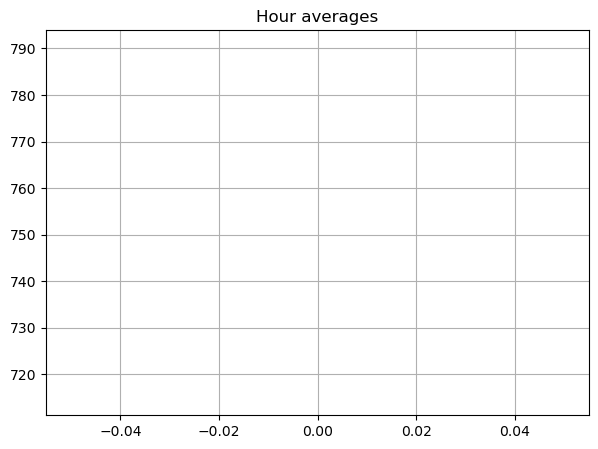

In [21]:
average_hour = code_mean(train, "hour", "num_sold")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

Finally, let's put all the transformations together in a single function .

In [23]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

NameError: name 'ads' is not defined

We see some overfitting! Hour_average was so great in the training dataset that the model decided to concentrate all of its forces on it. As a result, the quality of prediction dropped. This problem can be solved in a variety of ways; for example, we can calculate the target encoding not for the whole train set, but for some window instead. That way, encodings from the last observed window will most likely better describe the current series state. Alternatively, we can just drop it manually since we are sure that it makes things only worse in this case.


In [ ]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Regularization and feature selection
As we already know, not all features are equally healthy -- some may lead to overfitting while others should be removed. Besides manual inspection, we can apply regularization. Two of the most popular regression models with regularization are Ridge and Lasso regressions. They both add some more constrains to our loss function.

In the case of Ridge regression, those constraints are the sum of squares of the coefficients multiplied by the regularization coefficient. The bigger the coefficient a feature has, the bigger our loss will be. Hence, we will try to optimize the model while keeping the coefficients fairly low.

As a result of this L2
 regularization, we will have higher bias and lower variance, so the model will generalize better (at least that's what we hope will happen).

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values of the coefficients. As a result, during the optimization process, coefficients of unimportant features may become zeroes, which allows for automated feature selection. This regularization type is called L1
.

First, let's make sure that we have features to drop and that the data has highly correlated features.

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

We can clearly see some coefficients are getting closer and closer to zero (though they never actually reach it) as their importance in the model drops.


In [ ]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Lasso regression turned out to be more conservative; it removed 23-rd lag from the most important features and dropped 5 features completely, which only made the quality of prediction better.


Boosting
Why shouldn't we try XGBoost now?


In [ ]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

We have a winner! This is the smallest error on the test set among all the models we've tried so far.

But, this victory is decieving, and it might not be the brightest idea to fit xgboost as soon as you get your hands on time series data. Generally, tree-based models handle trends in data poorly when compared with linear models. In that case, you would have to detrend your series first or use some tricks to make the magic happen. Ideally, you can make the series stationary and then use XGBoost. For example, you can forecast trend separately with a linear model and then add predictions from xgboost to get a final forecast.

Conclusion
We discussed different time series analysis and prediction methods. Unfortunately, or maybe luckily, there is no one way to solve these kind of problems. Methods developed in the 1960s (and some even in the beginning of the 21st century) are still popular, along with LSTMs and RNNs (not covered in this article). This is partially related to the fact that the prediction task, like any other data-related task, requires creativity in so many aspects and definitely requires research. In spite of the large number of formal quality metrics and approaches to parameters estimation, it is often necessary to try something different for each time series. Last but not least, the balance between quality and cost is important. As a good example, the SARIMA model can produce spectacular results after tuning but can require many hours of tambourine dancing time series manipulation while a simple linear regression model can be built in 10 minutes and can achieve more or less comparable results.

Useful resources
Online textbook for the advanced statistical forecasting course at Duke University - covers various smoothing techniques in detail along with linear and ARIMA models
Comparison of ARIMA and Random Forest time series models for prediction of avian influenza H5N1 outbreaks - one of a few cases where using random forest for time series forecasting is actively defended
Time Series Analysis (TSA) in Python - Linear Models to GARCH - applying the ARIMA models family to the task of modeling financial indicators (by Brian Christopher)